# Liquidity Integrated Long Term Portfolio

In this notebook we set out to analyze a Long-Term return portfolio in conjunction with allocation to money market funds and add some constraints for integrating liquidity into the portfolio

In [142]:
#fetching data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import LinearConstraint, Bounds, minimize

try:
    import pdblp

    con = pdblp.BCon(debug=True, port=8194, timeout=5000)
    con.start()
    con.debug = False
except:
    pass

In [143]:
tickers = ['SPY US Equity', 'EEM US Equity', 'REET US Equity', 'ALTY US Equity', 'IPO US Equity', 'VBK US Equity', 
           'PSP US Equity', 'IGEB US Equity', 'TLH US Equity', 'VYM US Equity', 'TLT US Equity']

start_date = '20171001'
end_date = '20241001'
rf = 3.78/100

try:
    return_index = pd.read_csv(r'universe_index_returns.csv', header=0, index_col=0)
    return_index.index = pd.to_datetime(return_index.index)
    
except:
    return_index = pd.DataFrame()
    
    for ticker in tickers:
        print(ticker)
        rt = con.bdh(ticker, ['TOT_RETURN_INDEX_NET_DVDS'], start_date, end_date)
        rt = rt[ticker][rt[ticker].columns[0]]
        if ticker == 'SPY US Equity':
            return_index.index = rt.index
            return_index[ticker] = rt.values
        else:
            rt.name = ticker
            return_index = return_index.merge(rt, on=['date'], how = 'left')

return_index

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,252.3200,44.8200,25.5500,15.7100,26.7797,153.8400,63.4500,50.4126,136.1600,81.5300,124.2800
2017-10-31,257.1500,46.2800,25.3100,15.5190,28.0400,156.1900,64.1000,50.5300,136.1000,82.4800,124.4600
2017-11-30,265.0100,46.1000,26.0300,15.4757,27.7953,160.9800,62.6000,50.5684,135.8984,85.0100,125.3839
2017-12-29,268.2131,47.8374,26.3659,15.6109,28.2089,161.4039,64.0802,50.5876,136.6807,86.2729,127.6508
2018-01-31,283.3294,51.8069,25.9616,15.6212,28.3340,167.6654,68.6096,50.5007,133.1232,89.8194,123.4950
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,588.3497,48.6078,29.6061,19.1468,39.6741,260.4799,97.3776,58.3782,120.1737,147.4197,105.7993
2024-06-28,609.1095,49.8814,29.9060,19.2511,40.7742,260.8175,95.6467,58.7169,122.0315,146.9544,107.7163
2024-07-31,616.4852,50.3030,31.7840,19.8841,40.7033,272.5795,102.2069,60.1582,126.2809,154.0543,111.6327


In [144]:
# Converting to monthly returns
return_index = return_index.ffill()
dates = pd.date_range(start = start_date, end = end_date, freq= 'M')
return_index['date'] = return_index.index
return_index_monthly = pd.DataFrame(columns = return_index.columns)
return_index_monthly.loc[len(return_index_monthly)] = return_index.iloc[0]

for i in range(len(dates)):
    temp = return_index[(return_index['date'] <= dates[i])]
    return_index_monthly.loc[len(return_index_monthly)] = temp.iloc[-1]

return_index_monthly.set_index('date', inplace=True)
returns_monthly = return_index_monthly.pct_change()
returns_monthly

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-31,0.019142,0.032575,-0.009393,-0.012158,0.047062,0.015276,0.010244,0.002329,-0.000441,0.011652,0.001448
2017-11-30,0.030566,-0.003889,0.028447,-0.002790,-0.008727,0.030668,-0.023401,0.000760,-0.001481,0.030674,0.007423
2017-12-29,0.012087,0.037688,0.012904,0.008736,0.014880,0.002633,0.023645,0.000380,0.005757,0.014856,0.018080
2018-01-31,0.056359,0.082979,-0.015334,0.000660,0.004435,0.038794,0.070683,-0.001718,-0.026028,0.041108,-0.032556
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.050580,0.019517,0.043850,0.023510,0.055420,0.035165,0.039055,0.020991,0.027923,0.030308,0.028841
2024-06-28,0.035285,0.026202,0.010130,0.005447,0.027728,0.001296,-0.017775,0.005802,0.015459,-0.003156,0.018119
2024-07-31,0.012109,0.008452,0.062797,0.032881,-0.001739,0.045097,0.068588,0.024547,0.034822,0.048314,0.036358


In [145]:
# Creating a standard 60/40 Portfolio (60% Equity and 40% US 10 Yr T-Bills
portfolio_60_40 = returns_monthly[['SPY US Equity', 'TLT US Equity']]
portfolio_60_40['portfolio'] = 0.6*portfolio_60_40['SPY US Equity'] + 0.4*portfolio_60_40['TLT US Equity']
portfolio_60_40 = portfolio_60_40.loc[portfolio_60_40.index[23]:]
portfolio_60_40.iloc[0] = [0,0,0]
portfolio_60_40

/var/folders/pm/gt8b21b163b9y6dl2hrphyr40000gn/T/ipykernel_66436/2219228112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_60_40['portfolio'] = 0.6*portfolio_60_40['SPY US Equity'] + 0.4*portfolio_60_40['TLT US Equity']


,SPY US Equity,TLT US Equity,portfolio
date,,,
2019-08-30,0.000000,0.000000,0.000000
2019-09-30,0.019479,-0.026800,0.000967
2019-10-31,0.022105,-0.011136,0.008808
2019-11-29,0.036198,-0.004069,0.020091
2019-12-31,0.029034,-0.031961,0.004636
...,...,...,...
2024-05-31,0.050580,0.028841,0.041884
2024-06-28,0.035285,0.018119,0.028419
2024-07-31,0.012109,0.036358,0.021809


In [146]:
# Getting Cumulative Returns for the 60/40 Portfolio
portfolio_60_40_cumulative = (portfolio_60_40.fillna(0) + 1).cumprod()
portfolio_60_40_cumulative

,SPY US Equity,TLT US Equity,portfolio
date,,,
2019-08-30,1.000000,1.000000,1.000000
2019-09-30,1.019479,0.973200,1.000967
2019-10-31,1.042014,0.962362,1.009784
2019-11-29,1.079733,0.958447,1.030072
2019-12-31,1.111082,0.927814,1.034847
...,...,...,...
2024-05-31,1.946040,0.684849,1.313618
2024-06-28,2.014706,0.697258,1.350950
2024-07-31,2.039102,0.722609,1.380412


In [147]:
money_market_funds = pd.read_csv(r"money_market_funds_spaxx_us_equity.csv", header=0, index_col=0)
money_market_funds.rename(columns={'TOT_RETURN_INDEX_NET_DVDS': 'money_market'}, inplace=True)
money_market_funds.index = pd.to_datetime(money_market_funds.index)

money_market_funds = money_market_funds.ffill()
dates = pd.date_range(start = start_date, end = end_date, freq= 'M')
money_market_funds['date'] = money_market_funds.index
money_market_funds_monthly = pd.DataFrame(columns = money_market_funds.columns)
money_market_funds_monthly.loc[len(money_market_funds_monthly)] = money_market_funds.iloc[0]

for i in range(len(dates)):
    temp = money_market_funds[(money_market_funds['date'] <= dates[i])]
    money_market_funds_monthly.loc[len(money_market_funds_monthly)] = temp.iloc[-1]

money_market_funds_monthly.set_index('date', inplace=True)
money_market_funds_returns_monthly = money_market_funds_monthly.pct_change()
money_market_funds_returns_monthly

,money_market
date,
2017-10-02,NaN
2017-10-31,0.000000
2017-11-30,0.000000
2017-12-28,0.000000
2018-01-31,0.000000
...,...
2024-05-30,0.000000
2024-06-27,0.008929
2024-07-31,0.000000


# Backtest

In [148]:
optimal_weights = pd.DataFrame(columns = tickers)
returns_monthly = returns_monthly[tickers]
optimal_vol = {}
prev_date = returns_monthly.index[24]

# We do a 5 year backtest and use historical covriances and returns as our estimates of expected returns and expected covariances
for date in returns_monthly.index[24:]:
    temp_returns = returns_monthly.loc[:date]
    returns = list(temp_returns.mean().values)
    cov_matrix = temp_returns.cov()

    def vol(x):
        return (np.matrix(x)*(np.matrix(cov_matrix))*np.matrix(x).T)[0,0]

    def return_constraint(target_return):
        return LinearConstraint(returns, target_return/12, np.inf)

    weight_sum_constraint = LinearConstraint(np.ones([1,11]), 1, 1)
    min_weight_constraint = LinearConstraint(np.eye(11), lb=0.01)
    x0 = [1/11]*11

    solution = minimize(vol, x0, constraints = [weight_sum_constraint, min_weight_constraint, return_constraint(0.105)])
    print(solution.success)
    if solution.success:
        optimal_weights.loc[date] = solution.x
        optimal_vol[date] = (solution.fun*12)**0.5
    else:
        optimal_weights.loc[date] = optimal_weights.loc[prev_date]
        optimal_vol[date] = optimal_vol[prev_date]
    prev_date = date

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [149]:
optimal_returns = (np.matrix(optimal_weights)*np.matrix(returns_monthly.loc[returns_monthly.index[24]:].T)).diagonal()
optimal_returns = np.squeeze(np.asarray(optimal_returns))

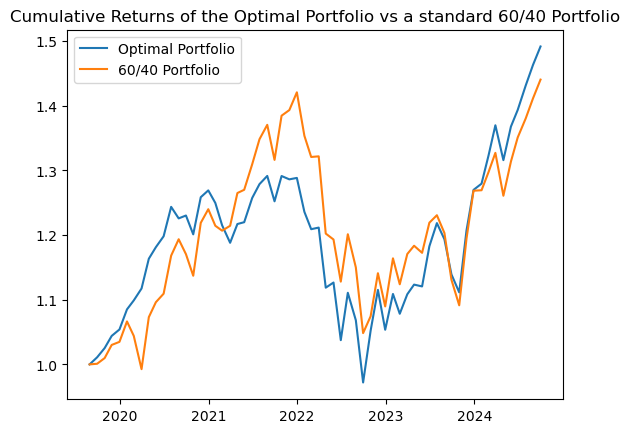

60/40 Portfolio Mean Return (%):  8.03
Optimal Portfolio Mean Return (%):  8.57
60/40 Portfolio Vol (%):  13.82
Optimal Portfolio Vol (%):  12.74
60/40 Portfolio Sharpe:  0.31
Optimal Portfolio Sharpe:  0.38


In [150]:
optimal_returns_df = pd.DataFrame(data = np.matrix(optimal_returns).T ,columns = ['opt_port_monthly_returns'], 
                                  index = returns_monthly.index[24:])
optimal_returns_df.loc[returns_monthly.index[23]] = 0
optimal_returns_df.sort_index(inplace=True)
optimal_returns_df['cumulative_returns'] = (optimal_returns_df['opt_port_monthly_returns'] + 1).cumprod()
optimal_returns_df

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(portfolio_60_40_cumulative['portfolio'], label='60/40 Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs a standard 60/40 Portfolio')
plt.show()

print('60/40 Portfolio Mean Return (%): ', round(portfolio_60_40['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print('60/40 Portfolio Vol (%): ', round(portfolio_60_40['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print('60/40 Portfolio Sharpe: ', 
      round((portfolio_60_40['portfolio'].mean()*12 - rf)/(portfolio_60_40['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))

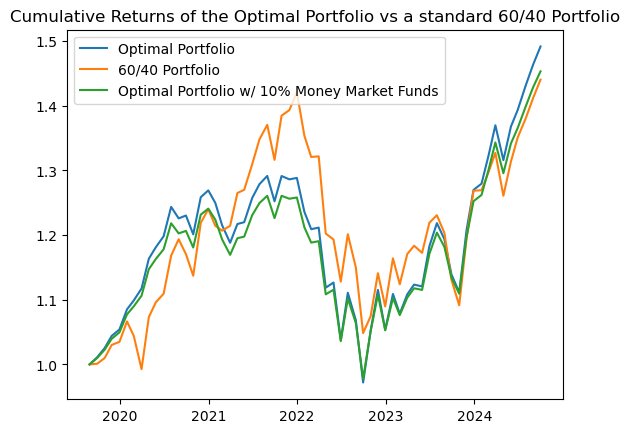

60/40 Portfolio Mean Return (%):  8.03
Optimal Portfolio Mean Return (%):  8.57
Optimal Portfolio w/ Money Market Mean Return (%):  7.91
60/40 Portfolio Vol (%):  13.82
Optimal Portfolio Vol (%):  12.74
Optimal Portfolio w/ Money Market Vol (%):  11.49
60/40 Portfolio Sharpe:  0.31
Optimal Portfolio Sharpe:  0.38
Optimal Portfolio w/ Money Market Sharpe:  0.36


In [151]:
optimal_returns_df.reset_index(inplace=True)
optimal_returns_df['money_market_returns'] = list(money_market_funds_returns_monthly.reset_index().iloc[23:]['money_market'])
optimal_returns_df['opt_port_w_money_market'] = 0.9*optimal_returns_df['opt_port_monthly_returns'] + 0.1*optimal_returns_df[
    'money_market_returns']
optimal_returns_df['opt_port_w_money_market_cumulative'] = (optimal_returns_df['opt_port_w_money_market'] + 1).cumprod()
optimal_returns_df.set_index('date', inplace=True)

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(portfolio_60_40_cumulative['portfolio'], label='60/40 Portfolio')
plt.plot(optimal_returns_df['opt_port_w_money_market_cumulative'], label='Optimal Portfolio w/ 10% Money Market Funds')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs a standard 60/40 Portfolio')
plt.show()

print('60/40 Portfolio Mean Return (%): ', round(portfolio_60_40['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print(f'Optimal Portfolio w/ Money Market Mean Return (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].mean()*12*100, 2))

print('60/40 Portfolio Vol (%): ', round(portfolio_60_40['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio w/ Money Market Vol (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)*100, 2))

print('60/40 Portfolio Sharpe: ', 
      round((portfolio_60_40['portfolio'].mean()*12 - rf)/(portfolio_60_40['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))
print('Optimal Portfolio w/ Money Market Sharpe: ', 
      round((optimal_returns_df['opt_port_w_money_market'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)), 2))

# Constrained Optimization for Liquidity Management

In [152]:
bid_ask_spread = pd.read_csv(r'historical_bid_ask_%.csv', header=0, index_col=0)
bid_ask_spread.index = pd.to_datetime(bid_ask_spread.index)
bid_ask_spread = bid_ask_spread.reindex(returns_monthly.index)
bid_ask_spread

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,0.0040,0.0223,0.1663,2.8453,0.5122,0.0391,0.1258,0.1233,0.0294,0.0136,0.0085
2017-10-31,0.0039,0.0217,0.1479,NaN,0.3077,0.0519,0.1482,0.1093,0.0257,0.0140,0.0082
2017-11-30,0.0038,0.0216,0.1224,3.6943,0.2825,0.1058,0.1686,0.1118,0.0422,0.0130,0.0081
2017-12-29,0.0038,0.0212,0.1036,3.4485,0.1801,0.0758,0.2193,0.1302,0.0477,0.0132,0.0080
2018-01-31,0.0038,0.0197,0.0958,0.6435,0.1669,0.0738,0.1586,0.1662,0.0477,0.0134,0.0084
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.0027,0.0240,0.0455,0.4651,0.1039,0.0501,0.6735,0.0288,0.0144,0.0121,0.0111
2024-06-28,0.0030,0.0234,0.0456,0.3029,0.0538,0.0513,0.7048,0.0352,0.0155,0.0142,0.0108
2024-07-31,0.0036,0.0233,0.0429,0.4492,0.1228,0.0778,0.4798,0.0292,0.0164,0.0217,0.0106


In [153]:
div_yld = pd.read_csv(r'historical_indicated_div_yld.csv', header=0, index_col=0)
div_yld.ffill(limit=30)
div_yld.index = pd.to_datetime(div_yld.index)
div_yld = div_yld.reindex(returns_monthly.index)
div_yld.fillna(0, inplace=True)
div_yld

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,1.9572,0.8555,3.4670,6.9510,0.2347,0.5408,13.8963,3.2702,1.8300,2.9535,2.4370
2017-10-31,1.9204,0.8285,3.4999,7.0365,0.2241,0.5327,13.7554,3.2959,1.9311,2.9195,2.5365
2017-11-30,1.8634,0.8317,3.4031,7.0978,0.2261,0.5168,14.0850,3.3089,1.8729,2.8326,2.4428
2017-12-29,2.0255,2.9565,0.2700,9.9599,0.0000,1.3782,11.5904,4.4031,2.0944,3.0041,2.4742
2018-01-31,1.9175,2.7300,0.2742,9.9533,0.0000,1.3267,10.8252,3.1511,1.9001,2.8855,2.4889
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,1.2097,3.5800,2.3084,7.0923,0.0000,0.6468,3.2710,5.0572,4.2297,2.1850,4.0901
2024-06-28,1.2929,1.3611,1.2471,7.0955,0.0760,0.6622,23.0355,4.5697,4.0707,3.4526,3.8061
2024-07-31,1.2774,1.3497,1.1734,6.9100,0.0761,0.6336,21.5570,5.0069,3.9778,3.2935,3.9851


In [154]:
optimal_weights = pd.DataFrame(columns = tickers)
returns_monthly = returns_monthly[tickers]
optimal_vol = {}

# We do a 5 year backtest and use historical covriances and returns as our estimates of expected returns and expected covariances
for date in returns_monthly.index[24:]:
    temp_returns = returns_monthly.loc[:date]
    returns = list(temp_returns.mean().values)
    div_yld_at_d = div_yld.loc[date].values
    bid_ask_at_d = bid_ask_spread.loc[date].values
    cov_matrix = temp_returns.cov()

    def vol(x):
        return (np.matrix(x)*(np.matrix(cov_matrix))*np.matrix(x).T)[0,0]

    def return_constraint(target_return):
        return LinearConstraint(returns, target_return/12, np.inf)
    
    def div_yld_constraint(target_div_yld):
        return LinearConstraint(div_yld_at_d, target_div_yld, np.inf)
    
    def bid_ask_constraint(target_bid_ask_spread):
        return LinearConstraint(bid_ask_at_d, 0, target_bid_ask_spread)

    weight_sum_constraint = LinearConstraint(np.ones([1,11]), 1, 1)
    min_weight_constraint = LinearConstraint(np.eye(11), lb=0.01)
    x0 = [1/11]*11

    solution = minimize(vol, x0, constraints = [weight_sum_constraint, min_weight_constraint, return_constraint(0.105),
                                               div_yld_constraint(2), bid_ask_constraint(0.1)])
    print(solution.success)
    if solution.success:
        optimal_weights.loc[date] = solution.x
        optimal_vol[date] = (solution.fun*12)**0.5
    else:
        optimal_weights.loc[date] = optimal_weights.loc[prev_date]
        optimal_vol[date] = optimal_vol[prev_date]
    prev_date = date

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True


In [155]:
optimal_returns = (np.matrix(optimal_weights)*np.matrix(returns_monthly.loc[returns_monthly.index[24]:].T)).diagonal()
optimal_returns = np.squeeze(np.asarray(optimal_returns))

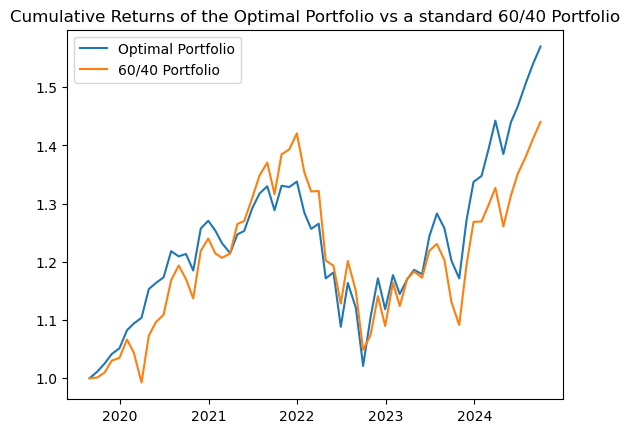

60/40 Portfolio Mean Return (%):  8.03
Optimal Portfolio Mean Return (%):  9.54
60/40 Portfolio Vol (%):  13.82
Optimal Portfolio Vol (%):  12.55
60/40 Portfolio Sharpe:  0.31
Optimal Portfolio Sharpe:  0.46


In [156]:
optimal_returns_df = pd.DataFrame(data = np.matrix(optimal_returns).T ,columns = ['opt_port_monthly_returns'], 
                                  index = returns_monthly.index[24:])
optimal_returns_df.loc[returns_monthly.index[23]] = 0
optimal_returns_df.sort_index(inplace=True)
optimal_returns_df['cumulative_returns'] = (optimal_returns_df['opt_port_monthly_returns'] + 1).cumprod()
optimal_returns_df

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(portfolio_60_40_cumulative['portfolio'], label='60/40 Portfolio')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs a standard 60/40 Portfolio')
plt.show()

print('60/40 Portfolio Mean Return (%): ', round(portfolio_60_40['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print('60/40 Portfolio Vol (%): ', round(portfolio_60_40['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print('60/40 Portfolio Sharpe: ', 
      round((portfolio_60_40['portfolio'].mean()*12 - rf)/(portfolio_60_40['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))

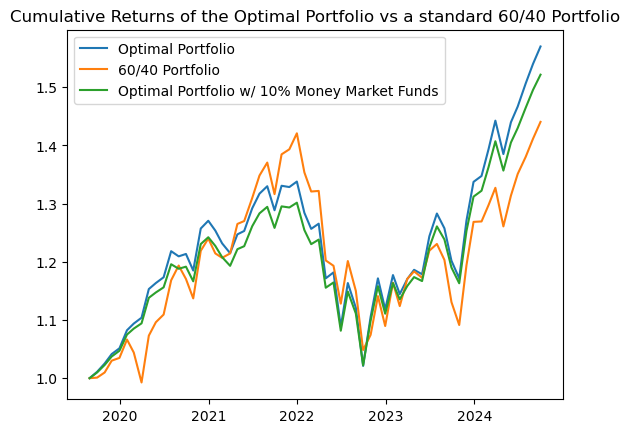

60/40 Portfolio Mean Return (%):  8.03
Optimal Portfolio Mean Return (%):  9.54
Optimal Portfolio w/ Money Market Mean Return (%):  8.78
60/40 Portfolio Vol (%):  13.82
Optimal Portfolio Vol (%):  12.55
Optimal Portfolio w/ Money Market Vol (%):  11.32
60/40 Portfolio Sharpe:  0.31
Optimal Portfolio Sharpe:  0.46
Optimal Portfolio w/ Money Market Sharpe:  0.44


In [160]:
optimal_returns_df.reset_index(inplace=True)
optimal_returns_df['money_market_returns'] = list(money_market_funds_returns_monthly.reset_index().iloc[23:]['money_market'])
optimal_returns_df['opt_port_w_money_market'] = 0.9*optimal_returns_df['opt_port_monthly_returns'] + 0.1*optimal_returns_df[
    'money_market_returns']
optimal_returns_df['opt_port_w_money_market_cumulative'] = (optimal_returns_df['opt_port_w_money_market'] + 1).cumprod()
optimal_returns_df.set_index('date', inplace=True)

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(portfolio_60_40_cumulative['portfolio'], label='60/40 Portfolio')
plt.plot(optimal_returns_df['opt_port_w_money_market_cumulative'], label='Optimal Portfolio w/ 10% Money Market Funds')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs a standard 60/40 Portfolio')
plt.show()

print('60/40 Portfolio Mean Return (%): ', round(portfolio_60_40['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print(f'Optimal Portfolio w/ Money Market Mean Return (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].mean()*12*100, 2))

print('60/40 Portfolio Vol (%): ', round(portfolio_60_40['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio w/ Money Market Vol (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)*100, 2))

print('60/40 Portfolio Sharpe: ', 
      round((portfolio_60_40['portfolio'].mean()*12 - rf)/(portfolio_60_40['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))
print('Optimal Portfolio w/ Money Market Sharpe: ', 
      round((optimal_returns_df['opt_port_w_money_market'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)), 2))

# TODO
1. Compute Max Drawdown
2. Compute Tracking Error vs 60/40
3. 2-sided Turnover for Portfolio
4. Compute Correlation Matrix and Beta w/ S&P and 60/40
5. Compute Information Ratio vs 60/40
6. Hedging Portfolio? (dependent on beta, I think). The portfolio actually performs really well during covid drop so I am not sure if we need that
7. Factor in growing median age
8. BBG PORT Scenario Analysis and VaR/IVAR computations